In [621]:
from pandas import read_csv

def read_data(file_path, num_features = 1):
    series_influ_A_df = read_csv(file_path, engine='python')
    series_influ_A_df = series_influ_A_df.rename(columns= {"Influenza A - All types of surveillance": "case"})

    # because since 2011-03-01 It was announced that the H1N12009 flu had been controlled and treated as regular seasonal flu and
    # since 2020-02-01, it's time for covid 
    
    series_influ_A_df = series_influ_A_df.loc [(series_influ_A_df['Month'] >='2011-04-01') & (series_influ_A_df['Month'] <='2020-02-01')]
    return series_influ_A_df.dropna()[["case", "temp"]]

file_path = '../../temp_data/influA_vietnam_temp_month.csv'
#Load data set
df = read_data(file_path)

In [622]:
import numpy as np
from sklearn.metrics import r2_score

# def create_dataset(dataset, look_back=2, num_predict=1):
#     dataX, dataY = [], []
#     for i in range(0, len(dataset)-2 *look_back+1, look_back - num_predict):
#         a = dataset[i:(i+look_back)]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back - num_predict : i+ 2*look_back-num_predict])
#     return np.array(dataX), np.array(dataY)

def create_dataset(dataset, look_back=1, num_predict = 1):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-look_back, num_predict):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back: i+ look_back +num_predict])
    return np.array(dataX), np.array(dataY)

def forecast(input, model):
    input = input.reshape(1, input.shape[0], input.shape[1])
    predicted = model.predict(input, verbose=0)
    return predicted[0]

def make_forecasts(test, model):
    forecasts = []
    inputStart = test[0]
    inputX = inputStart.reshape(1, inputStart.shape[0], inputStart.shape[1])
    for i in range(len(test)):
        predicted = forecast(inputX[i], model)
        print(predicted.shape)
        forecasts.append(predicted)
        inputXContinue = np.vstack((inputX[-1][predicted.shape[0]:], predicted))
        inputX = np.append(inputX, [inputXContinue], axis=0)
    
    return np.array(forecasts)
def evaluate_forecasts(test, forecasts):
    from sklearn.metrics import mean_squared_error
    testScore = np.sqrt(mean_squared_error(test, forecasts))
    print('Test Score: %.2f RMSE' % (testScore))

def plot_r2(x,y, file_path=None):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy import stats

    # Generate some sample data
    # x = y_inverse.flatten()
    # y = y_hat_inverse.flatten()

    # Compute the linear regression line
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    # Create the R-squared line
    r2_line = slope * x + intercept
    r2 = r2_score(x, y)
    r2_pearson = r_value**2
    squared_error = np.square(x-y)

    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, label='Data Points')
    plt.plot(x, squared_error, color='red', marker="o", label=f'squared Error (R²={r2:.2f})')

    # Add labels and title
    plt.xlabel('actual number of infection')
    plt.ylabel('forecast number of infection')
    plt.title('Scatter Plot with R-squared Line')
    plt.legend()
    plt.grid()
    # plt.savefig(file_path)
    # plt.close()
    plt.show()

def plot(testY, forecasts):
    import matplotlib.pyplot as plt
    forecastsPlot = np.empty([forecasts.shape[0]])
    forecastsPlot[:] = np.nan
    forecastsPlot[:] = forecasts[:,0].reshape(-1)
    testPlot = np.empty([testY.shape[0]])
    testPlot[:] = np.nan
    testPlot[:] = testY[:,0].reshape(-1)
    plt.plot(testPlot, "-y", label="actual", marker= '.')
    plt.plot(forecastsPlot, color = 'green', label="forecast", marker='x')
    plt.ylabel("Number of infections")
    plt.legend(["actual", "forecast"])
    plt.show()
    
def plot_month_per_year(df, key):
    import plotly.graph_objects as go
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=df['Month'], y=df[key], mode='lines+markers', name=f'Influenza A Cases in month'))
    fig.update_layout(
        title='Influenza A Cases Over Time',
        xaxis=dict(
            title='Month',
            tickvals=df['Month'],  
            tickformat='%Y-%m',
            tickangle=90,
        ),
        yaxis=dict(title='Number of Cases'),
        showlegend=True,
    )
 
    # Show plot
    fig.show()
def inverse_transform(data, scaler):
    flattened_data = data.flatten()
    inverse_flattened_data = scaler.inverse_transform(flattened_data.reshape(-1,1))
    return inverse_flattened_data.reshape(data.shape)

In [623]:
# Preprocessing
def find_outliers_IQR(df):

    q1=df.quantile(0.25)

    q3=df.quantile(0.75)

    IQR=q3-q1

    outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]

    return outliers

outliers = find_outliers_IQR(df['case'])

print('number of outliers: '+ str(len(outliers)))

print('max outlier value: '+ str(outliers.max()))

print('min outlier value: '+ str(outliers.min()))

number of outliers: 4
max outlier value: 158.0
min outlier value: 120.0


In [624]:
def impute_outliers_IQR(df):

    q1=df.quantile(0.25)

    q3=df.quantile(0.75)

    IQR=q3-q1

    upper = df[~(df>(q3+1.5*IQR))].max()

    lower = df[~(df<(q1-1.5*IQR))].min()

    df = np.where(
        df > upper,
        np.nan,
        np.where(df < lower,np.nan,df)
        )
    return df
impute_df = df.copy()
impute_df['case'] = impute_outliers_IQR(df['case'])
# plot_month_per_year(impute_df, 'case')

In [625]:
linear_df = impute_df.copy()
linear_df['case'] = linear_df['case'].interpolate(method='linear')
# plot_month_per_year(linear_df, 'case')

In [626]:
spline_order_df = impute_df.copy()
spline_order_df['case'] = spline_order_df['case'].interpolate(method='spline', order=3)
# plot_month_per_year(spline_order_df, 'case')

In [627]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
def moving_average(data, window_size):
    return data.rolling(window=window_size).mean()

def exponential_moving_average(data, span):
    return data.ewm(span=span, adjust=False).mean()

def prepare_data(df, is_ma=False, scaler =None):
    import pandas as pd
    df_ = pd.DataFrame()
    df_ = df.copy()
    if is_ma:
        # Apply Moving Average Filter
        window_size = 2
        
        df_['case'] = exponential_moving_average(df_['case'], window_size)
        df_ = df_.dropna()
    dataset = df_.values
    if scaler:
        flattened_dataset = dataset.flatten()
        dataset_trans = scaler.fit_transform(flattened_dataset.reshape(-1,1))
        dataset = dataset_trans.reshape(dataset.shape)
    return  dataset

scaler = MinMaxScaler()
dataset = prepare_data(df = linear_df, scaler=scaler, is_ma=True)

In [628]:

#process data
num_predict = 8
look_back = 8
test_size = num_predict
length = len(dataset)
dataset_length = length - (length -look_back) % num_predict
rest = length - dataset_length
dataset = dataset[rest:]
train = dataset[: -test_size,:]
test = dataset[-test_size - look_back:,:]

trainX, trainY = create_dataset(train, look_back, num_predict)
testX, testY = create_dataset(test, look_back, num_predict)

In [629]:
# i = 86
# print(trainX[i], trainY[i])
# len(trainX)
# j=0
# print(testX[j], testY[j])
import tensorflow as tf
from keras.losses import mean_squared_error, huber
def custom_loss(y_true, y_pred):
    return tf.sqrt(mean_squared_error(y_true, y_pred)/2)

# def custom_loss(y_true, y_pred):
#     """
#     Custom loss function that penalizes high losses.
#     """
#     # Calculate the standard loss
#     standard_loss = mean_squared_error(y_true ,y_pred)

#     # Apply a penalty function to the loss
#     penalty_factor = 3.0  # Adjust this value to control the penalty strength
#     penalty = tf.maximum(standard_loss - 0.05, 0.0) * penalty_factor

#     # Combine the standard loss and the penalty
#     total_loss = tf.sqrt(standard_loss) + penalty

#     return total_loss
def trend_loss(y_true, y_pred):
    """
    Custom loss function that focuses on capturing the trend of the time series.
    """
    true_trend = tf.math.subtract(y_true[:, 1:], y_true[:, :-1])
    pred_trend = tf.math.subtract(y_pred[:, 1:], y_pred[:, :-1])

    # Calculate the mean squared error of the trends
    trend_mse = tf.sqrt(mean_squared_error(true_trend, pred_trend))

    return trend_mse

def custom_loss_hubber_loss(y_true, y_pred):
    print(y_true.shape)
    hubber_loss = huber(y_true, y_pred, 0.1)
    trend_weight = 0
    trend_loss_value = trend_loss(y_true, y_pred)
    return (1 - trend_weight) *hubber_loss + trend_weight * trend_loss_value


In [630]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, TimeDistributed, Input, Dropout, GRU,concatenate, Bidirectional
from sklearn.model_selection import GridSearchCV
from keras.saving import register_keras_serializable
from sklearn.metrics import r2_score


# hybrid model

# def build_model(input_shape, dropout=None, dense_units = [], unit=64, optimizer='adam'):
#     input = Input(shape=input_shape)
#     # LSTM Model
#     lstm_model = Sequential([
#         LSTM(unit, activation='relu'),
#     ])

#     # GRU Model
#     gru_model = Sequential([
#         # Input(input_shape=input_shape),
#         GRU(unit, activation='relu'),
#     ])

#     gru_model1 = Sequential([
#         # Input(input_shape=input_shape),
#         GRU(unit, activation='relu'),
#     ])

#     # GRU Model
#     rnn_model = Sequential([
#         # Input(input_shape=input_shape),
#         SimpleRNN(unit, activation='relu'),
#     ])

#     gru_output = gru_model(input)
#     gru_output1 = gru_model1(input)
#     # lstm_output = lstm_model(input)
#     rnn_output = rnn_model(input)
#     # gru_output1 = gru_model1(input)

#     combined_output = concatenate([ rnn_output, gru_output, gru_output1])

#     dense_layers = Sequential([
#     Dense(units=input_shape[1], activation='sigmoid' )
#     ])

#     final_output = dense_layers(combined_output)
#     model = tf.keras.Model(inputs=input, outputs=final_output)
#     model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta=0.1), metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

#loss=tf.keras.losses.Huber(delta=0.1)

# def build_model(input_shape, dropout=None, unit=64, optimizer='adam'):
#     model = Sequential()
#     model.add(Input(shape=input_shape))
#     # model.add(GRU(units=unit, activation='relu', return_sequences=True))
#     model.add(SimpleRNN(units=unit, activation='relu'))
#     # model.add(LSTM(units=unit, activation='relu'))
#     model.add(Dense(units=input_shape[1], activation='sigmoid' ))
#     model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta=0.15), metrics=[tf.keras.metrics.RootMeanSquaredError()])
#     return model

def build_model(input_shape, dropout=None, unit=64, optimizer='adam'):
    input = Input(shape=input_shape)

    # GRU Model
    rnn_model = Sequential([
        # Input(input_shape=input_shape),
        LSTM(unit, activation='relu', return_sequences=True),
    ])

    rnn_output = rnn_model(input)

    dense_layers = Sequential([
    TimeDistributed(Dense(units=input_shape[1], activation='sigmoid' ))
    ])

    output = dense_layers(rnn_output[:,-num_predict:])
    model = tf.keras.Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss=tf.keras.losses.Huber(delta=0.15), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model



In [631]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os
model = build_model(input_shape=(trainX.shape[1], trainX.shape[2]), unit=32)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
file_path = os.path.join('../model', 'test.keras')

mc = ModelCheckpoint(file_path, monitor='loss', mode='min', verbose=1, save_best_only=True)

model.fit(trainX, trainY,batch_size=1, callbacks=[es, mc], verbose=0, epochs=200)


Epoch 1: loss improved from inf to 0.03034, saving model to ../model\test.keras

Epoch 2: loss improved from 0.03034 to 0.02914, saving model to ../model\test.keras

Epoch 3: loss improved from 0.02914 to 0.02768, saving model to ../model\test.keras

Epoch 4: loss improved from 0.02768 to 0.02581, saving model to ../model\test.keras

Epoch 5: loss improved from 0.02581 to 0.02310, saving model to ../model\test.keras

Epoch 6: loss improved from 0.02310 to 0.01961, saving model to ../model\test.keras

Epoch 7: loss improved from 0.01961 to 0.01713, saving model to ../model\test.keras

Epoch 8: loss improved from 0.01713 to 0.01676, saving model to ../model\test.keras

Epoch 9: loss improved from 0.01676 to 0.01618, saving model to ../model\test.keras

Epoch 10: loss improved from 0.01618 to 0.01577, saving model to ../model\test.keras

Epoch 11: loss improved from 0.01577 to 0.01543, saving model to ../model\test.keras

Epoch 12: loss improved from 0.01543 to 0.01515, saving model to .

In [632]:
# from keras.models import load_model
# import os
# file_path = os.path.join('../model', 'test.keras')
# model = load_model(file_path, custom_objects={"custom_loss": custom_loss})


forecasts = make_forecasts(testX, model)
# invert predictions
forecasts = inverse_transform(forecasts, scaler)
testY_ = inverse_transform(testY, scaler)
# evaluate_forecasts(testY_[:,0].reshape(-1), forecasts[:, 0].reshape(-1))

(8, 2)


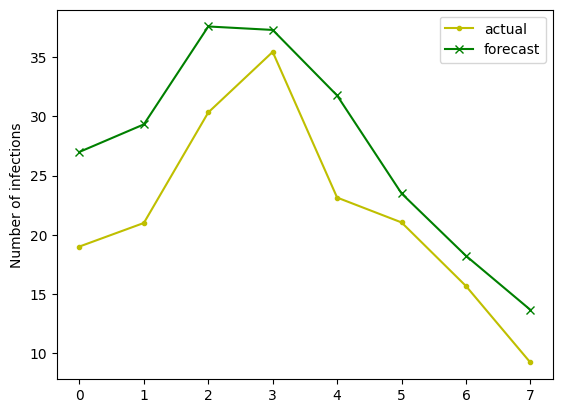

In [633]:
new_shape = (testY_.shape[0] * testY_.shape[1], testY_.shape[2])
plot(testY_.reshape(new_shape), forecasts.reshape(new_shape))

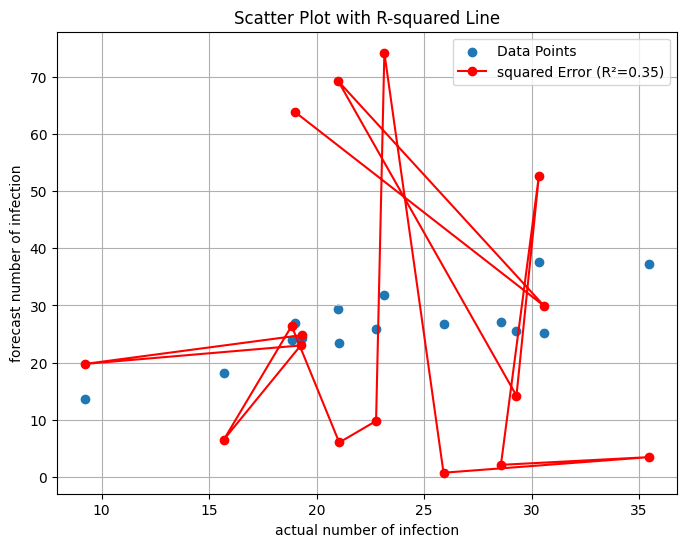

In [634]:
plot_r2(testY_.reshape(new_shape).flatten(), forecasts.reshape(new_shape).flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step


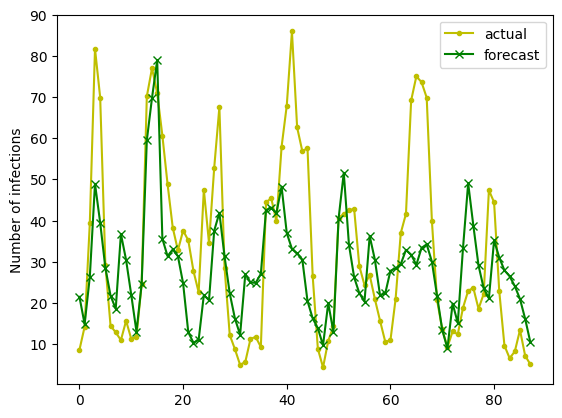

In [635]:
trainY_hat = model.predict(trainX)
trainY_hat_inverse = inverse_transform(trainY_hat, scaler)
trainY_inverse = inverse_transform(trainY, scaler)
new_shape_train = (trainY_inverse.shape[0] * trainY_inverse.shape[1], trainY_inverse.shape[2])
plot(trainY_inverse.reshape(new_shape_train), trainY_hat_inverse.reshape(new_shape_train))

In [636]:
from pandas import read_csv

def read_data(file_path, num_features = 1):
    series_influ_A_df = read_csv(file_path, engine='python')
    series_influ_A_df = series_influ_A_df.rename(columns= {"Influenza A - All types of surveillance": "case"})

    # because since 2011-03-01 It was announced that the H1N12009 flu had been controlled and treated as regular seasonal flu and
    # since 2020-02-01, it's time for covid 
    
    series_influ_A_df = series_influ_A_df.loc [(series_influ_A_df['Month'] >='2011-04-01') & (series_influ_A_df['Month'] <='2020-02-01')]
    return series_influ_A_df.dropna()

file_path = '../../temp_data/influA_vietnam_temp_month.csv'
#Load data set
df = read_data(file_path)

plot_month_per_year(df, 'case')